In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import scipy.optimize as op

# Programming Exercise 3: Multi-class Classification and Neural Networks

## 1. Multi-class Classification

Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. For this exercise, we will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9).

### 1.1 Dataset

The data set in `ex3data1.mat` contains 5000 training examples of handwritten digits culled from the MNIST handwritten digit dataset.

In [2]:
# Read .mat file
data = io.loadmat('ex3data1.mat')

# Separate into X and y values
X = data["X"]
y = data["y"]

Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

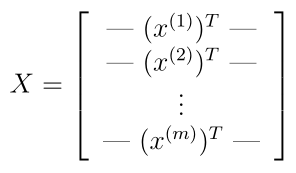

The second part of the training set is a 5000-dimensional vector $y$ that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, the digit zero has been mapped to the value ten. We undo this in the code snippet below, since we are using Python for this assignment.

In [3]:
# Remap all 10's to 0
y[y == 10] = 0

# Check unique values of y
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### 1.2 Visualizing the data

We begin by visualizing a subset of the training set. We select 100 random rows in matrix $X$ and map each one to a 20 pixel by 20 pixel grayscale image. The result is the figure below.

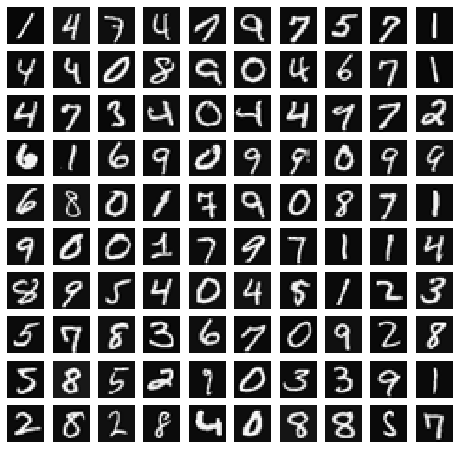

In [4]:
# Plot digits
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize = (8, 8))
for i in range(0, 100, 10):
    for j in range(10):
        # Choose random digit/row from X
        digit = X[np.random.randint(0, X.shape[0] + 1), :]
        
        # Plot digit
        ax[int(i/10),j].imshow(digit.reshape(20, 20, order = "F"), cmap = "gray")
        ax[int(i/10),j].axis("off")

### 1.3 Vectorizing Logistic Regression 

We will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well-vectorized. 

Fortunately for us, the code we implemented in Programming Exercise 2 on logistic regression has already been vectorized. We re-use the code for this in `lrCostFunction`, implemented below.

In [5]:
# sigmoid computes the sigmoid of each value of x (x can be a matrix, vector or scalar).
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
# lrCostFunction computes the cost and gradient for logistic regression with regularization
def lrCostFunction(theta, X, y, lmbda):
    # Initialize values
    m = len(y)
    J = 0
    grad = np.zeros((theta.shape[0], 1))

    # Compute for cost
    prediction = sigmoid(X @ theta)
    J = -(1 / m) * (y.T @ np.log(prediction) + (1 - y).T @ np.log(1 - prediction)) + (lmbda / (2 * m)) * (theta[1:].T @ theta[1:])

    # Compute for gradient
    error = prediction - y
    grad[0] = (1 / m) * np.sum(error * X[:, 0][:, np.newaxis])
    grad[1:] = (1 / m) * np.sum(error.T * X[:, 1:].T, axis = 1)[:, np.newaxis] + (lmbda / m) * theta[1:] 
    
    return np.asscalar(J), grad

In [7]:
#TESTS
theta_t = np.array([[-2], [-1], [1], [2]])
X_t = np.hstack((np.ones((5, 1)), np.arange(1, 16).reshape((3, 5)).T / 10))
y_t = np.array([[1], [0], [1], [0], [1]])
lambda_t = 3
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print("Cost: ", J)
print("Expected Cost: 2.534819")
print("Gradients: \n", grad)
print("Expected Gradients: \n 0.146561 \n -0.548558 \n 0.724722 \n 1.398003")

Cost:  2.534819396109744
Expected Cost: 2.534819
Gradients: 
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected Gradients: 
 0.146561 
 -0.548558 
 0.724722 
 1.398003


### 1.4 One-vs-all Classification

We will now implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K$ = 10, but your code should work for any value of $K$.

The function `oneVsAll` below trains one classifier for each class. In particular, the function returns all the classifier parameters in $\Theta$, a $K \times (N+1)$ matrix , where each row corresponds to the learned logistic regression parameters for one class. 

To perform the cost minimization, we use the `minimize` function from `scipy.optimize`. Again, as in the  Programming Assignment in Week 2, we will have to separate `lrCostFunction` from earlier into two -- one of which will output the cost (`lrCostFunction` below) and the other outputting the gradient (`lrGradient` below). Furthermore, we will use conjugate gradient/CG as our optimization method. Also, since `x0` must be a 1D array, we modify the functions accordingly to account for this, so that `theta` and `grad` are all 1-dimensional.


In [8]:
# lrCostFunction computes the cost for logistic regression with regularization
def lrCostFunction(theta, X, y, lmbda):
    # Initialize values
    m = len(y)
    J = 0

    # Compute for cost
    prediction = sigmoid(X @ theta[:, np.newaxis])
    J = -(1 / m) * (y.T @ np.log(prediction) + (1 - y).T @ np.log(1 - prediction)) + (lmbda / (2 * m)) * (theta[1:].T @ theta[1:])

    return np.asscalar(J)

# lrCostFunction computes the gradient for logistic regression with regularization
def lrGradient(theta, X, y, lmb):
    # Initialize values
    m = len(y)
    grad = np.zeros(theta.shape[0])

    # Compute for gradient
    prediction = sigmoid(X @ theta[:, np.newaxis])
    error = prediction - y
    grad[0] = (1 / m) * np.sum(error * X[:, 0][:, np.newaxis])
    grad[1:] = (1 / m) * np.sum(error.T * X[:, 1:].T, axis = 1) + (lmbda / m) * theta[1:]
    
    return grad

In [ ]:
# oneVsAll trains multiple logistic regression classifiers and returns all the classifiers 
# in a matrix all_theta, where the i-th row of all_theta corresponds to the classifier for label i
def oneVsAll(X, y, num_labels, lmbda):
    # Initialize variables
    num_examples, num_features = X.shape
    initial_theta = np.zeros(num_features + 1)
    all_theta = np.zeros((num_labels, num_features + 1))

    # Add ones to the X data matrix
    X = np.hstack((np.ones((num_examples, 1)), X))
    
    # Perform cost minimization
    for i in range(num_labels):
        y_i = np.where(y == i, 1, 0)
        result = op.minimize(fun = lrCostFunction, x0 = initial_theta, args = (X, y_i, lmbda), method = "CG", jac = lrGradient)
        opt_theta = result.x
        all_theta[i, :] = opt_theta
        
    return all_theta

In [ ]:
#Get all_theta for our dataset
lmbda = 0.1
num_labels = 10
all_theta = oneVsAll(X, y, num_labels, lmbda)

#### 1.4.1 One-vs-all Prediction

After training your one-vs-all classifier, we can now use it to predict the digit contained in a given image. For each input, we compute the “probability” that it belongs to each class using the trained logistic regression classifiers. 

`predictOneVsAll` (implemented below) picks the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, 2, $\ldots$, or $K$) as the prediction for the input example.

In [ ]:
#predictOneVsAll predicts the label for a trained one-vs-all classifier. The labels 
# are in the range 1..K, where K = size(all_theta, 1).
def predictOneVsAll(all_theta, X):
    # Initialize variables
    num_examples, num_features = X.shape

    # Add ones to the X data matrix
    X = np.hstack((np.ones((num_examples, 1)), X))
    
    # Compute "probability" for all training examples
    prob = X @ all_theta.T
    
    # Get maximum "probability" for each training example
    return np.argmax(prob, axis = 1)

In [ ]:
#TESTS

# Make prediction
lrPred = predictOneVsAll(all_theta, X)

# Compute for training accuracy
print("Training Set Accuracy: ", np.mean(lrPred == np.ravel(y)) * 100, "%")
print("The training set accuracy is about 94.9%")

The training accuracy is about 97.5% for the one-vs-all implementation of regularized logistic regression. We want to improve upon this by using a neural network.

## 2. Neural Networks

We will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this section, we will be using parameters from a neural network that we have already trained. The goal is to implement the feedforward
propagation algorithm to use our weights for prediction.

### 2.1 Model representation

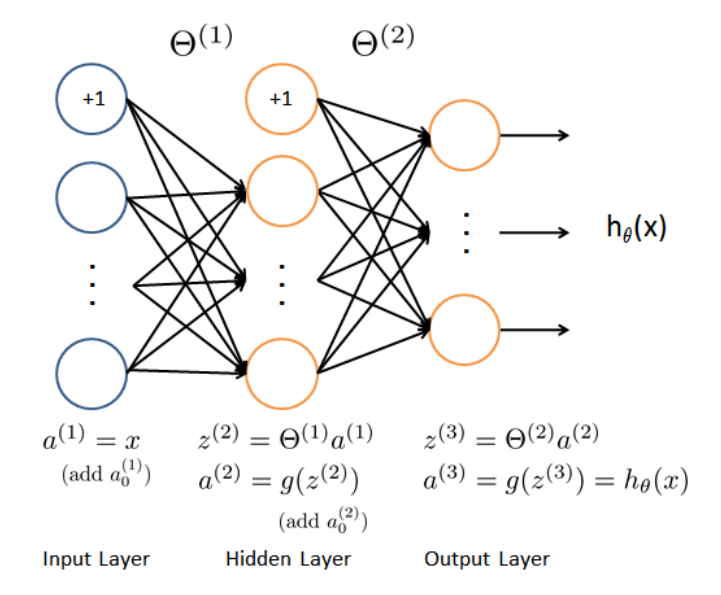

Our neural network is shown in the figure above. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 $\times$ 20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1).

We have been provided with a set of pre-trained network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$). These are stored in `ex3weights.mat` and will be loaded into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [ ]:
# Load the weights...
data_weights = io.loadmat('ex3weights.mat')

# ...into Theta1 and Theta2
Theta1 = data_weights["Theta1"]
Theta2 = data_weights["Theta2"]

### 2.2 Feedforward Propagation and Prediction

We will now implement feedforward propagation for the neural network. `predict` computes $h_{θ}(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $h_{θ}(x)_{k}$.

In [ ]:
#predict predicts the label of an input given a trained neural network
def predict(Theta1, Theta2, X):
    # Initialize variables
    num_examples, num_features = X.shape

    # Add ones to the X data matrix
    X = np.hstack((np.ones((num_examples, 1)), X))
    
    # Implement feedforward algorithm
    a1 = X
    a2 = sigmoid(a1 @ Theta1.T)
    
    # Add ones to the a2 matrix
    a2 = np.hstack((np.ones((a2.shape[0], 1)), a2))
    
    # Implement feedforward algorithm
    a3 = sigmoid(a2 @ Theta2.T)    
    
    # Get maximum "probability" for each training example
    return np.argmax(a3, axis = 1) + 1

Since the pre-trained weights assume that 0 is represented as 10 in $y$, we revert to this representation when we check for the training set accuracy.

In [ ]:
#TESTS

# Make prediction
nnPred = predict(Theta1, Theta2, X)

# Remap all 0's to 10
y[y == 0] = 10

# Compute for training accuracy
print("Training Set Accuracy: ", np.mean(nnPred == np.ravel(y)) * 100, "%")
print("The training set accuracy is about 97.5%")

The training accuracy is about 97.5% for the one-vs-all implementation of neural networks, a slight improvement from that from logistic regression.